# Churn Classification 

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import yellowbrick
from yellowbrick.classifier import ClassificationReport

## Read data into DataFrame

In [4]:
df = pd.read_csv(r"C:\Users\nsama\Desktop\CAKE_Data_Experiment_Task\task_data_churned.csv")
df.head()

,ws_users_activated,ws_users_deactivated,ws_users_invited,action_create_project,action_export_report,action_api_and_webhooks,action_time_entries_via_tracker,action_start_trial,action_import_csv,action_create_invoice,...,action_screenshots,action_create_custom_field,country,value_days_to_purchase,value_number_of_active_months,value_transactions_number,value_regular_seats,value_kiosk_seats,revenue,churned_status
0,3,2,0,5,8,0,0,0,0,0,...,NaN,NaN,Canada,2,0,6,3,0,184.925,No
1,6,1,0,35,106,0,33,0,1,0,...,NaN,3.0,United Kingdom,37,9,9,6,0,608.842,No
2,2,0,0,3,3,0,0,0,0,0,...,1.0,NaN,Florida,98,3,12,3,0,395.122,No
3,1,0,0,0,0,0,0,0,0,0,...,1.0,NaN,Kentucky,0,1,2,1,0,25.974,Yes
4,1,0,0,0,0,1,0,0,0,0,...,NaN,NaN,Ireland,21,2,3,1,0,38.961,Yes


In [5]:
df.shape

(2502, 26)

## Data Preprocessing
Aim: Explore and prepare raw data for application of Random Forest Classifier.   

### Verify and handle missing data

In [8]:
# Information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502 entries, 0 to 2501
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ws_users_activated               2502 non-null   int64  
 1   ws_users_deactivated             2502 non-null   int64  
 2   ws_users_invited                 2502 non-null   int64  
 3   action_create_project            2502 non-null   int64  
 4   action_export_report             2502 non-null   int64  
 5   action_api_and_webhooks          2502 non-null   int64  
 6   action_time_entries_via_tracker  2502 non-null   int64  
 7   action_start_trial               2502 non-null   int64  
 8   action_import_csv                2502 non-null   int64  
 9   action_create_invoice            2502 non-null   int64  
 10  action_lock_entries              2502 non-null   int64  
 11  action_add_targets               2502 non-null   int64  
 12  action_connect_quick

In [9]:
#df.columns

In [10]:
# Verify missing data
df.isnull().sum()

ws_users_activated                    0
ws_users_deactivated                  0
ws_users_invited                      0
action_create_project                 0
action_export_report                  0
action_api_and_webhooks               0
action_time_entries_via_tracker       0
action_start_trial                    0
action_import_csv                     0
action_create_invoice                 0
action_lock_entries                   0
action_add_targets                    0
action_connect_quickbooks             0
action_create_expense                 0
action_project_budget                 0
action_gps_tracking                1626
action_screenshots                 1458
action_create_custom_field         2059
country                              84
value_days_to_purchase                0
value_number_of_active_months         0
value_transactions_number             0
value_regular_seats                   0
value_kiosk_seats                     0
revenue                               0


In [11]:
# Categorical column 'country' fill missing value with 'Unknown'
df['country']=df['country'].fillna('Unknown')

In [12]:
unique_count=df['country'].nunique()
unique_count

156

### Encode categorical values to numerical

In [14]:
# Convert categorical column 'country' to numerical values
# Since we have many unique values we will replace country name with frequency of occurrence
frequency_encoding=df['country'].value_counts().to_dict()
df['country']=df['country'].map(frequency_encoding)

In [15]:
# Handle missing values for 'action_gps_tracking','action_screenshots' and 'action_create_custom_field'
colunm_names=['action_gps_tracking','action_screenshots', 'action_create_custom_field']
df[colunm_names]=df[colunm_names].fillna(df[colunm_names].mean())

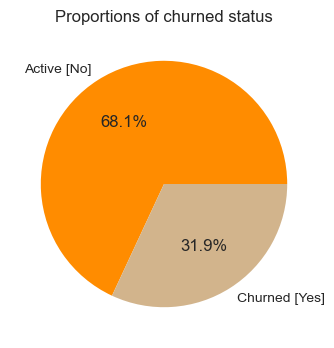

In [16]:
# Plot churned status proportions
# Aim of this step is to research if data is balanced (target classes have similar ratio) or imbalanced (data can influence on model bias)
# By observing the plot below we can conclude that data is slightly imbalanced

class_counts=df['churned_status'].value_counts(normalize=True)*100 
classes=class_counts.index
labels=['Active [No]','Churned [Yes]']
percentages=class_counts.values
plt.figure(figsize=(4,4))
plt.pie(percentages, 
        labels=labels, 
        autopct='%1.1f%%', 
colors=['darkorange','tan'],
)
plt.title('Proportions of churned status')
plt.show()

In [17]:
# Label for the dataset: column 'churned_status' convert Yes/No to 1/0
df['churned_status']=df['churned_status'].map({'Yes':1,'No':0})

###  Analyze Feature Correlation 
Aim: Understand relationship between features

- Strong correlation indicate that features are closely related (may represent similar information)
- Weak correlation indicate that features are not closely related (may bring valuable insights)

Observing the heatmap below we can see that:
- 'ws_users_activated' and 'value_regular_seats' have strong correlation 0.95
- 'revenue' and 'value_regular_seats' are strong correlated 0.82
- Features and target  are in negative correlation

Comment: Decision of how to handle strong correlated features depends on the data domain knowledge. For example we could drop one of high correlated features or apply some other measures.

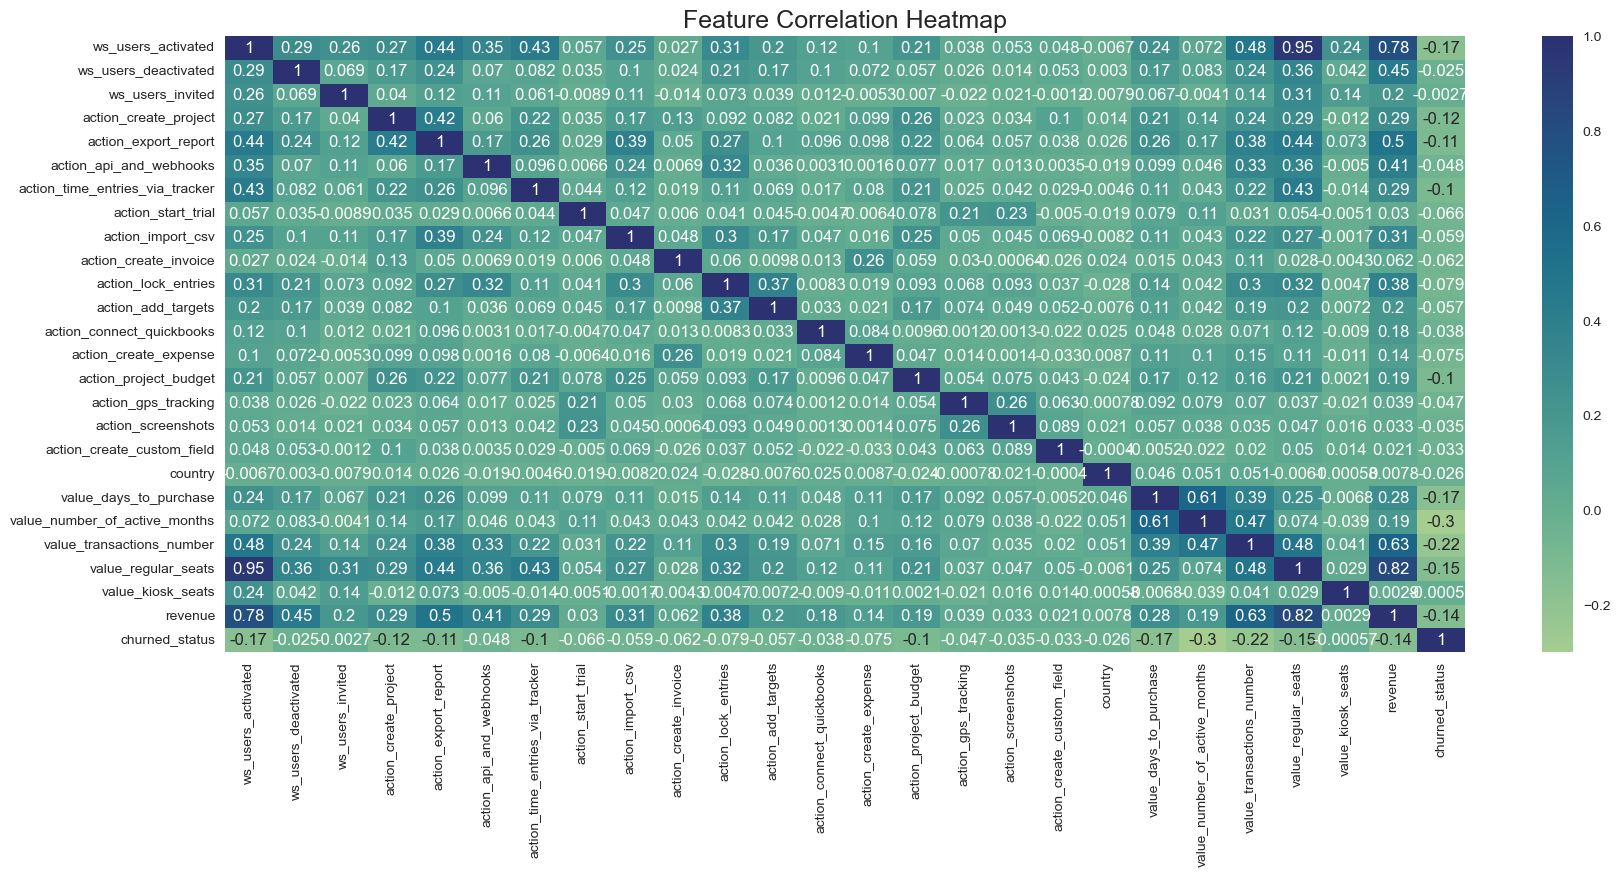

In [19]:
# Visual representation of Feature Correlation Heatmap
corr_mx=df.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(corr_mx, annot=True, cmap='crest')
plt.title('Feature Correlation Heatmap', fontsize=18)
plt.show()

In [20]:
# Print correlation with target column
corr_with_target=df.corr(method='pearson')['churned_status'].sort_values(ascending=False)
corr_with_target

churned_status                     1.000000
value_kiosk_seats                 -0.000573
ws_users_invited                  -0.002689
ws_users_deactivated              -0.025371
country                           -0.025993
action_create_custom_field        -0.032869
action_screenshots                -0.034945
action_connect_quickbooks         -0.037963
action_gps_tracking               -0.047366
action_api_and_webhooks           -0.048355
action_add_targets                -0.056659
action_import_csv                 -0.059408
action_create_invoice             -0.061822
action_start_trial                -0.066455
action_create_expense             -0.075356
action_lock_entries               -0.078791
action_time_entries_via_tracker   -0.100396
action_project_budget             -0.102300
action_export_report              -0.111169
action_create_project             -0.115451
revenue                           -0.142663
value_regular_seats               -0.150795
ws_users_activated              

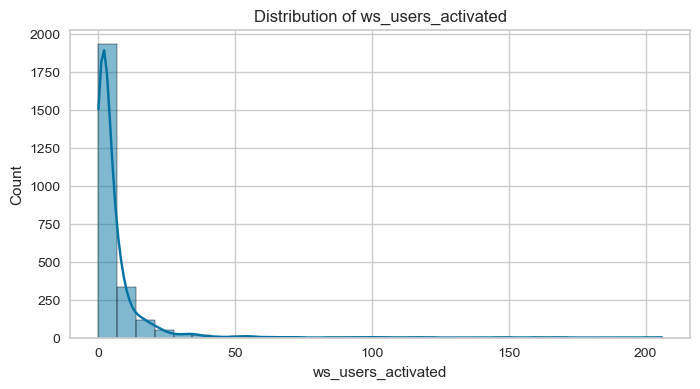

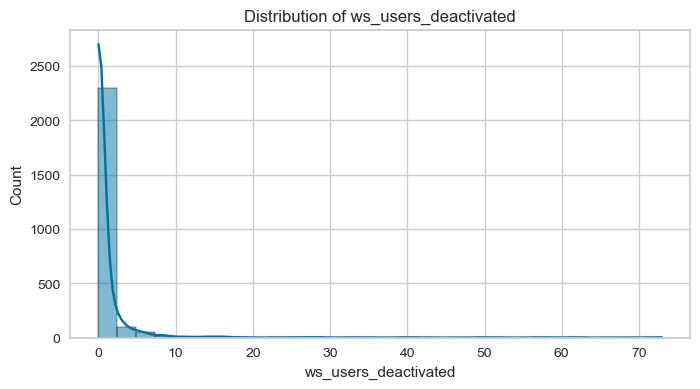

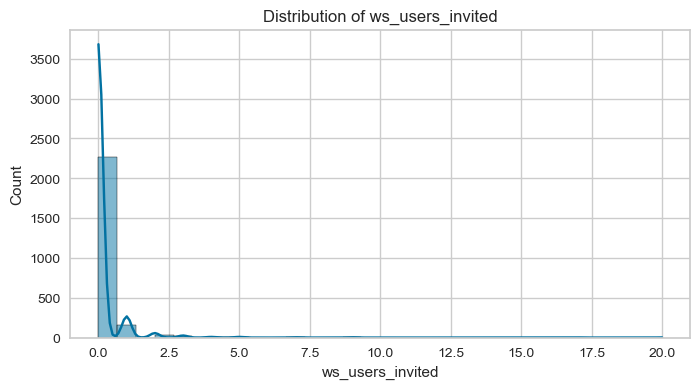

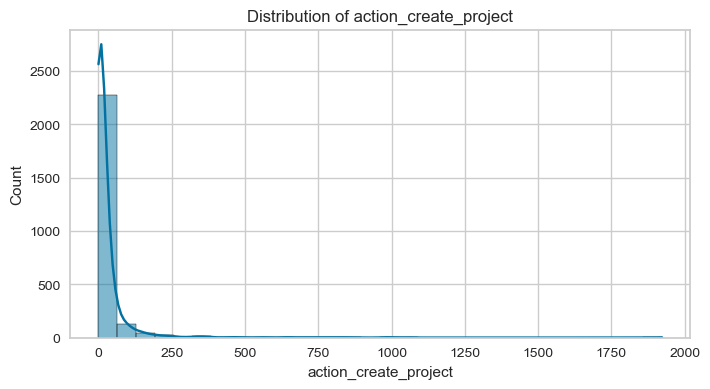

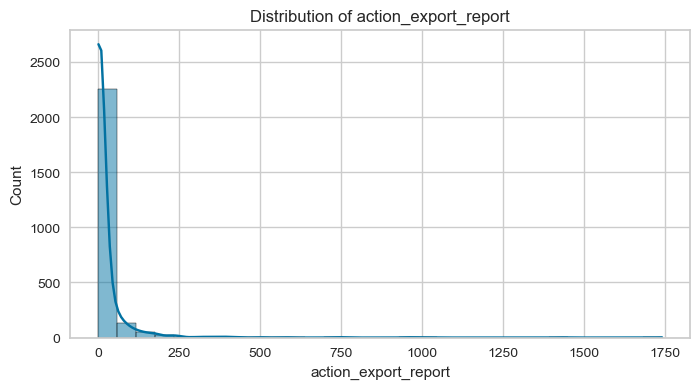

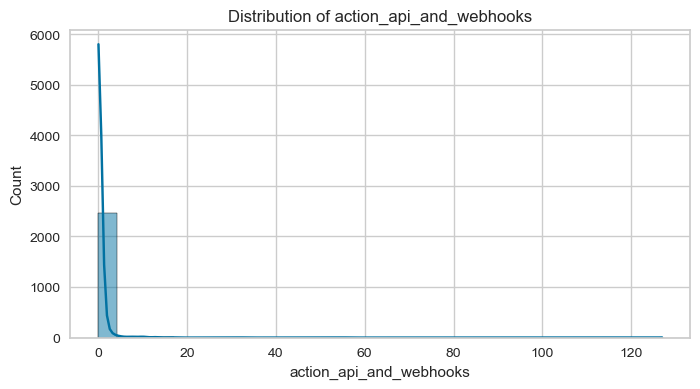

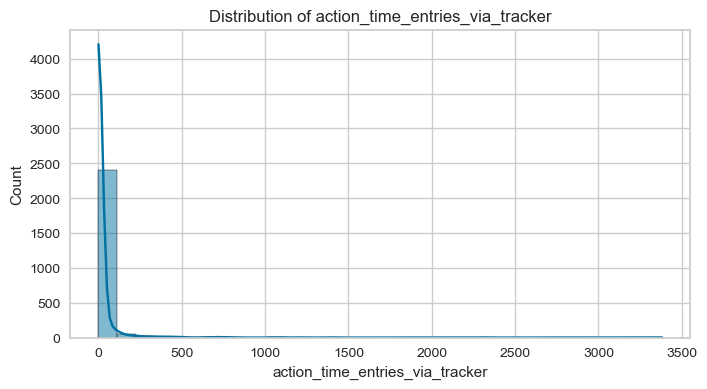

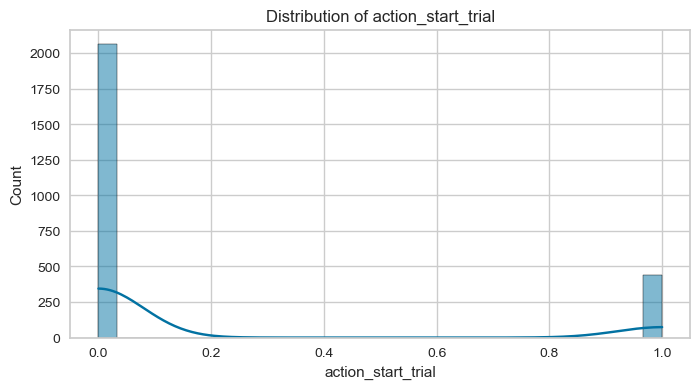

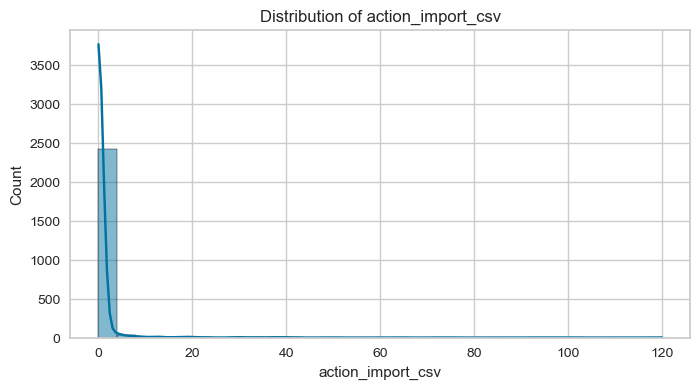

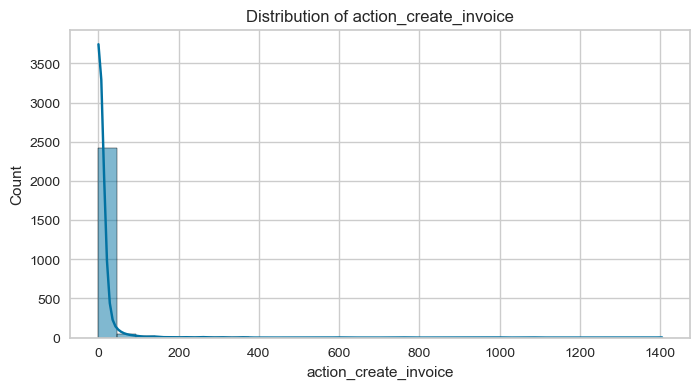

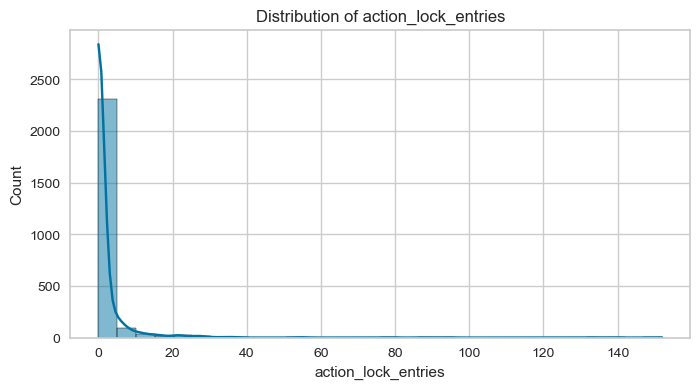

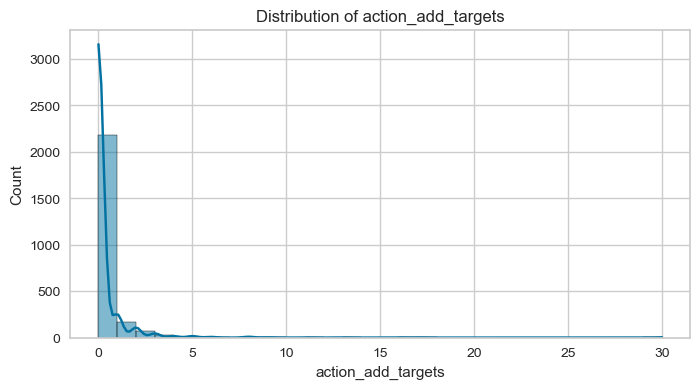

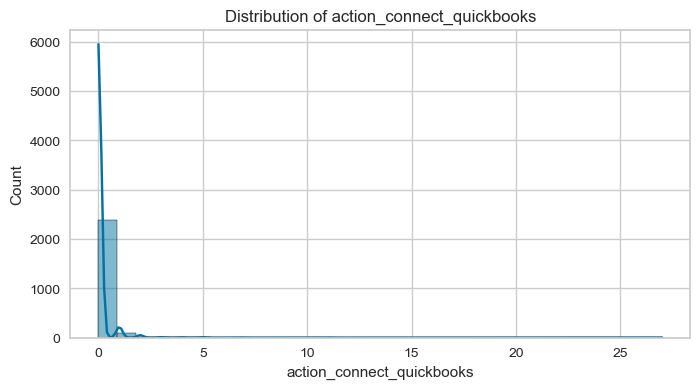

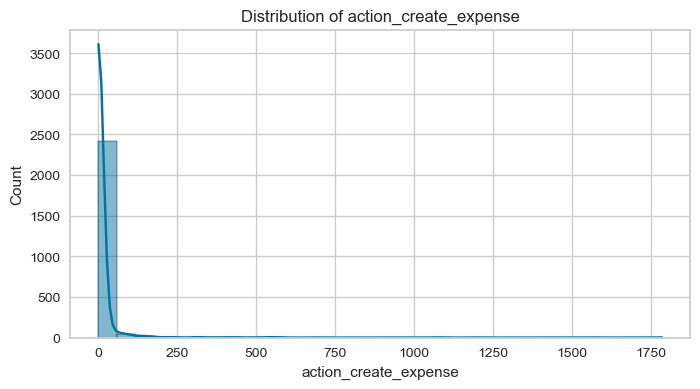

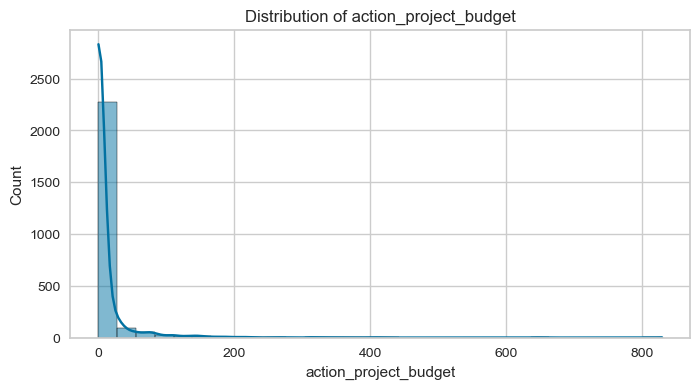

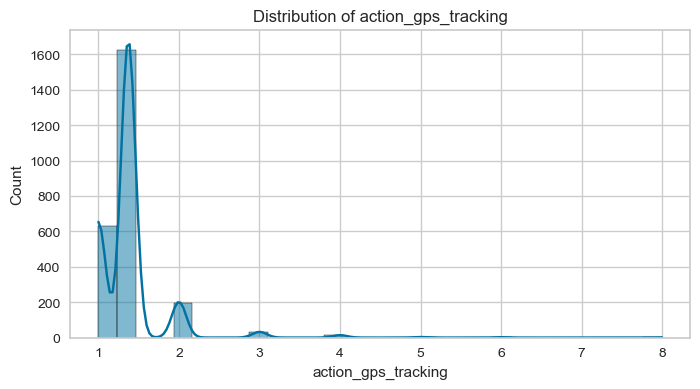

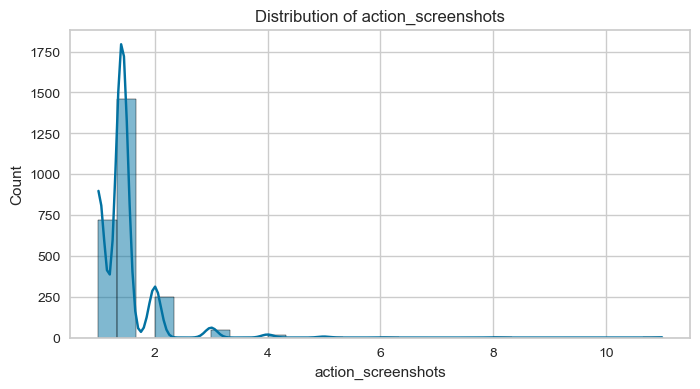

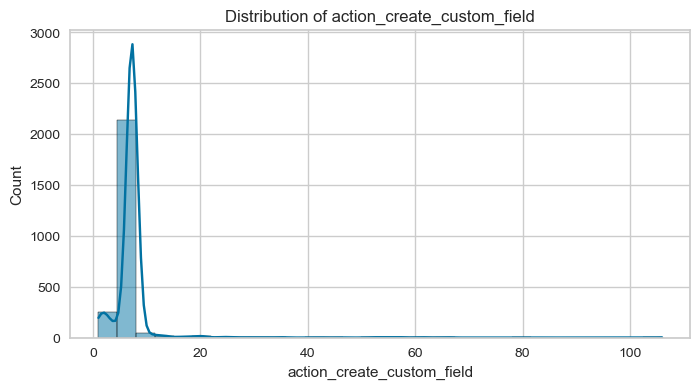

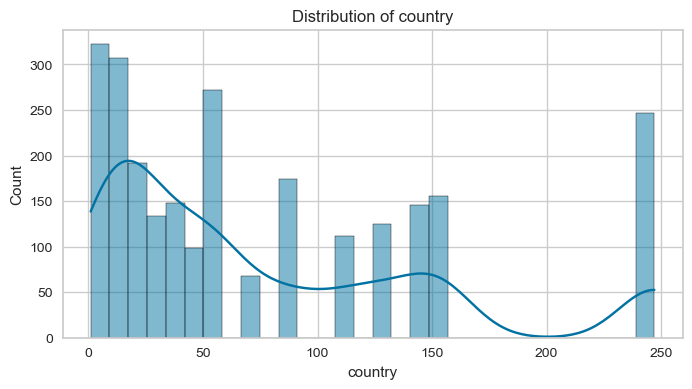

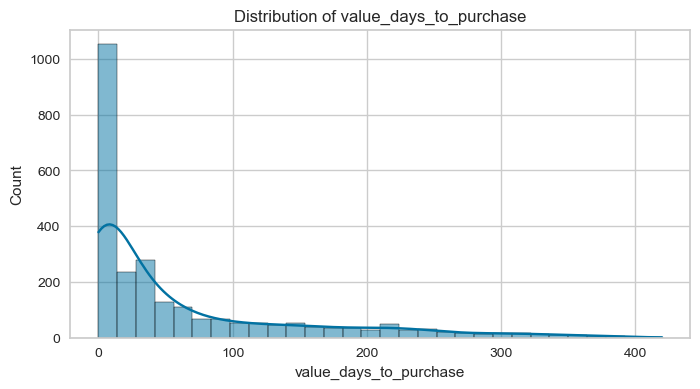

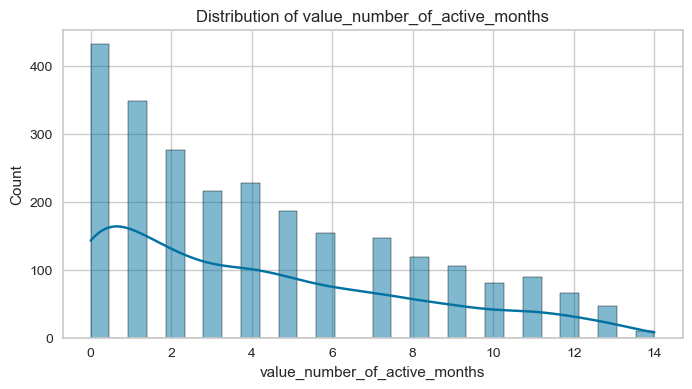

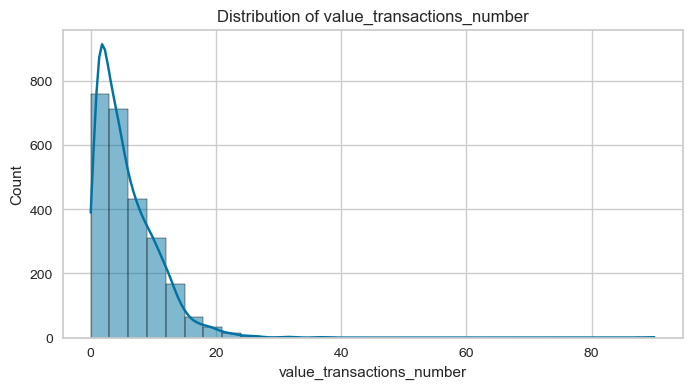

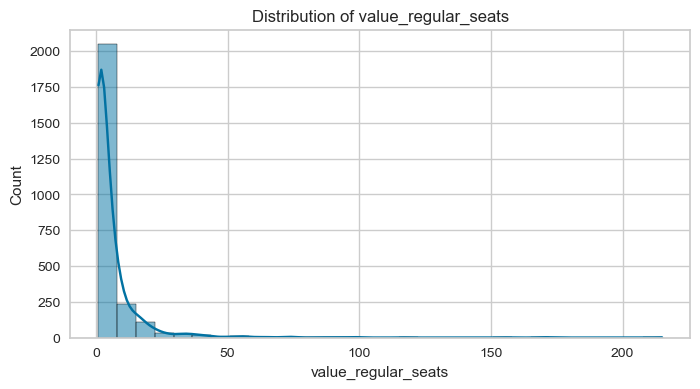

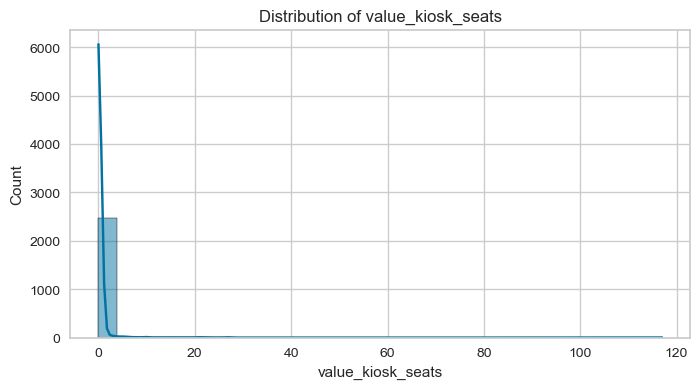

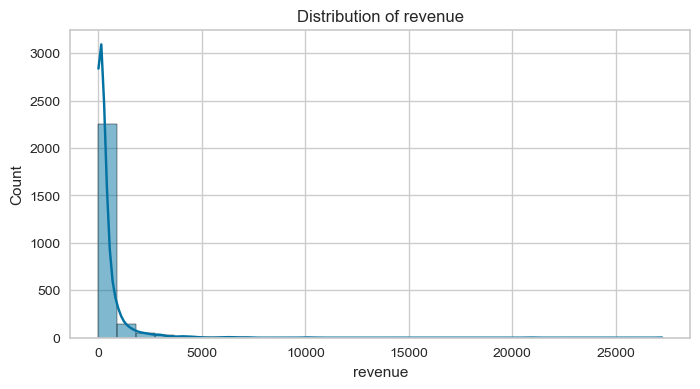

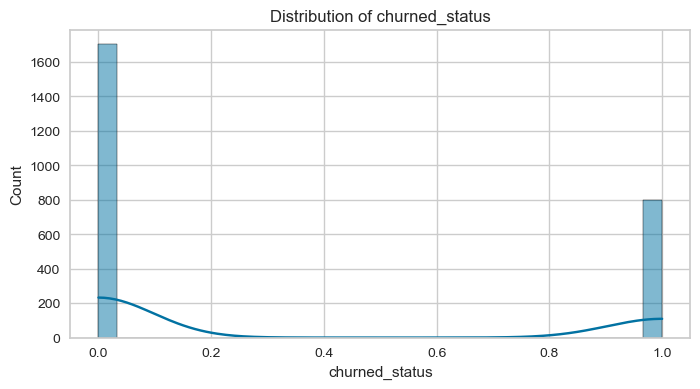

In [21]:
# Plot distribution of features 
for feature in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df[feature],kde=True,bins=30)
    plt.title(f'Distribution of {feature}')
    plt.show()

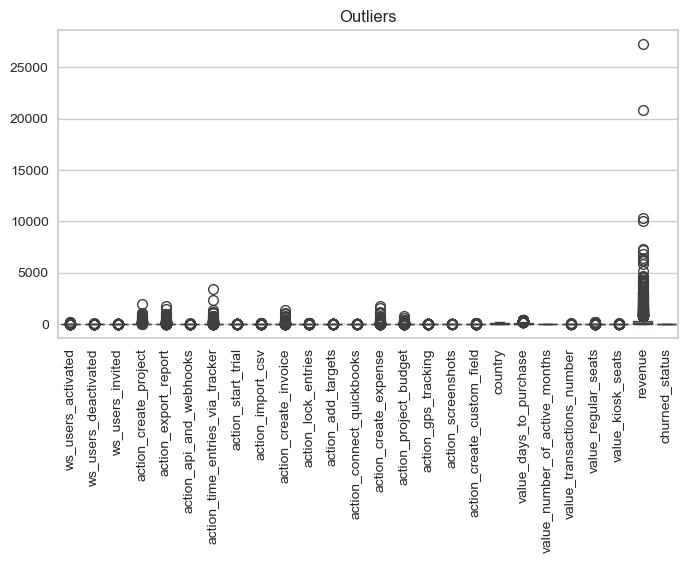

In [22]:
# Verify outliers
# Decision of how to handle outliers depends on the data domain knowledge. Further we will apply Random Forest Classifier which is robust to outliers.
plt.figure(figsize=(8,4))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title('Outliers')
plt.show()

## Random Forest Classifier

### Split data to train and test set

Aim: Before applying Random Forest Classifier we need to split data into train and test set and standardize features.
Usually train set contain 70-80% amount of data and test sets 20-30%.

Aftet that we will apply Random Forest Classifier and evaluate results

In [25]:
X=df[['ws_users_activated', 'ws_users_deactivated', 'ws_users_invited',
       'action_create_project', 'action_export_report',
       'action_api_and_webhooks', 'action_time_entries_via_tracker',
       'action_start_trial', 'action_import_csv', 'action_create_invoice',
       'action_lock_entries', 'action_add_targets',
       'action_connect_quickbooks', 'action_create_expense',
       'action_project_budget', 'action_gps_tracking', 'action_screenshots',
       'action_create_custom_field', 'country', 'value_days_to_purchase',
       'value_number_of_active_months', 'value_transactions_number',
       'value_regular_seats', 'value_kiosk_seats', 'revenue']].values 
y=df['churned_status'].values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
RandomForest=RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
RandomForest.fit(X_train_scaled, y_train)
y_pred= RandomForest.predict(X_test_scaled)

### Evaluation of Random Forest Classifier results
Observing the result we can see that Random Forest Classifier make correct prediction with accuracy score 76.3%.

Confusion matrix: Elements on diagonal represent the number of samples for which the prediction label is equal to true label.
Model have 63% accuracy for classification of Churned[Yes] customer and 13% accuracy for Active[No] customers.
7% of Churned[Yes] are classified as Active[No], and 16% Active[No] are classified as Churned[Yes].

Classification report:
- precision: 79% for Active[No] and 65% for Churned[Yes] 
- recall: 90% for Active[No] and 45% for Churned[Yes]
- f1-score: 84% for Active[No] and 53% fro Churned[Yes]

In [30]:
#Model Evaluation
accuracy_RandomForest = accuracy_score(y_test, y_pred)
conf_matix_RandomForest= confusion_matrix(y_test, y_pred)
calss_report_RandomForest = classification_report(y_test, y_pred)

In [31]:
print('Accuracy:',round(accuracy_RandomForest*100, 2), '%')

Accuracy: 76.3 %


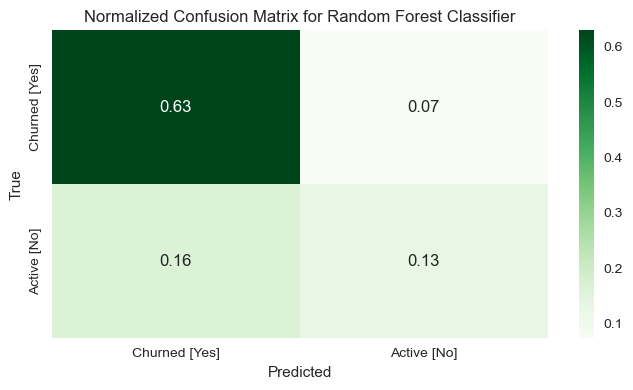

In [32]:
plt.figure(figsize=(8,4))
sns.heatmap(conf_matix_RandomForest/np.sum(conf_matix_RandomForest), annot=True, fmt='.2f', cmap='Greens', xticklabels=['Churned [Yes]','Active [No]'], yticklabels=['Churned [Yes]','Active [No]'])
plt.title('Normalized Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [63]:
#print('Classification Report:\n',calss_report_RandomForest)

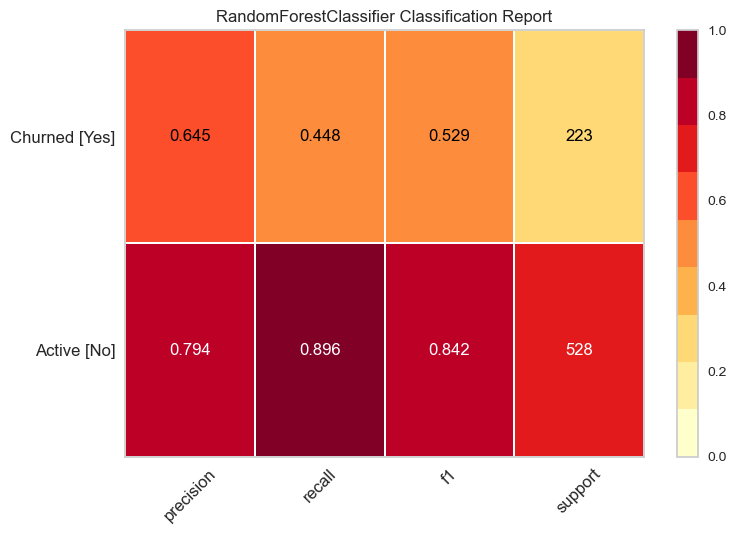

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [34]:
# Visual representation of Classification Report
classes=['Active [No]','Churned [Yes]']
visualizer = ClassificationReport(RandomForest, classes=classes, support=True)
visualizer.fit(X_train_scaled,y_train)  # Fit the visualizer and the model
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show() 